In [6]:
import os
import pandas as pd
from tqdm import tqdm
import time

df = pd.read_csv("./2023-02-27-yc-companies.csv")

shortened_df = df[~df['long_description'].isna()][:-2]
long_descriptions = shortened_df['long_description'].to_list()

In [2]:
from mistralai.client import MistralClient

mistral_client = MistralClient(api_key=os.environ.get("MISTRAL_API"))
all_vecs = []
for batch in tqdm(zip(*(iter(long_descriptions),) * 5)):
    embeddings_response = mistral_client.embeddings(
        model="mistral-embed",
        input=list(batch)
    )
    vecs = [vec.embedding for vec in embeddings_response.data]
    all_vecs += vecs
    time.sleep(1)

759it [17:10,  1.36s/it]


In [7]:
shortened_df['vector'] = all_vecs

In [8]:
shortened_df.to_parquet("last_1k_rows.parquet", index=False)

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine

df = pd.read_parquet("./last_1k_rows.parquet")
embeddings = df['vector'].to_list()
X_embedded = np.stack(embeddings)

In [3]:
import json
with open(f"./titles.json", "w") as f:
    json.dump(df['company_name'].to_list(), f) 

In [17]:
from umap import UMAP

def project(embeddings):
    mapper = UMAP(n_components=2, metric='cosine').fit(
        embeddings
    )
    return mapper.embedding_, mapper

projections, umap_mapper = project(X_embedded)

c:\Users\alvin\miniconda3\envs\hf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
from sklearn.neighbors import NearestNeighbors

ns = 200

nbrs = NearestNeighbors(n_neighbors=ns).fit(projections)
distances, indices = nbrs.kneighbors(projections)

In [19]:
distance_desc = sorted(distances[:,ns-1], reverse=True)

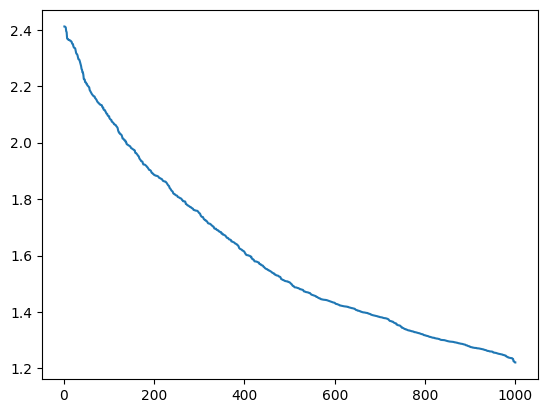

In [20]:
import matplotlib.pyplot as plt
plt.plot(range(1,len(distance_desc)+1), distance_desc)

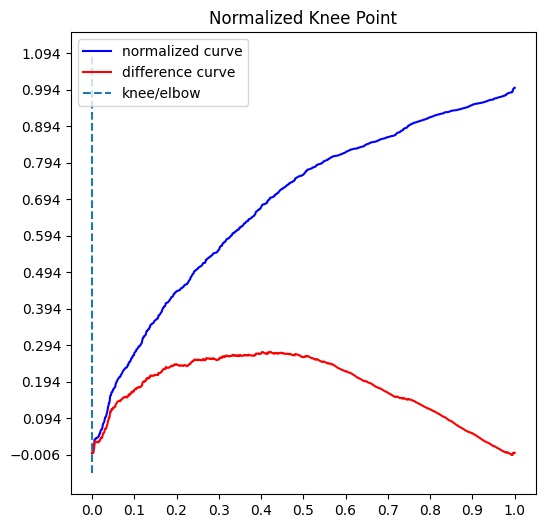

In [25]:
from kneed import KneeLocator
kneedle = KneeLocator(range(1,len(distance_desc)+1),  #x values
                      distance_desc, # y values
                      S=1.0, #parameter suggested from paper
                      curve="convex", #parameter from figure
                      direction="decreasing") #parameter from figure
kneedle.plot_knee_normalized()